In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../load_magic/storage.py
from itertools import groupby
import networkx as nx
import os
import re

s = Storage()
black_list = ['.git']
notebook_digraph = nx.DiGraph(env='jh')
repo_path = r'C:\Users\dev\Documents\Repositories\job-hunting'
functions_regex = re.compile(r'\b([he][ac]\.\w+)')

In [2]:

for sub_directory, directories_list, files_list in os.walk(repo_path):
    if all(map(lambda x: x not in sub_directory, black_list)):
        for file_name in files_list:
            if file_name.endswith('.ipynb'):
                if not file_name.endswith('-checkpoint.ipynb'):
                    file_path = os.path.join(sub_directory, file_name)
                    with open(file_path, 'r', encoding=s.encoding_type) as f:
                        ipynb_str = f.read()
                        calls_list = functions_regex.findall(ipynb_str)
                        if len(calls_list):
                            consecutives_list = []
                            for k, v in groupby(calls_list):
                                consecutives_list.append((k, len(list(v))))
                            #print(f'{file_name}: {consecutives_list}')
                            notebook_digraph.add_node(file_name, size=len(consecutives_list))
                            for call_tuple in consecutives_list:
                                call_name = call_tuple[0]
                                weight = call_tuple[1]
                                if call_name in notebook_digraph:
                                    size = notebook_digraph.nodes[call_name]['size']
                                    notebook_digraph.nodes[call_name]['size'] = size + weight
                                    if notebook_digraph.has_edge(file_name, call_name):
                                        size = notebook_digraph.get_edge_data(file_name, call_name)['weight']
                                        notebook_digraph.edges[file_name, call_name]['weight'] = size + weight
                                    else:
                                        notebook_digraph.add_edge(file_name, call_name, weight=weight)
                                else:
                                    notebook_digraph.add_node(call_name, size=weight)

In [145]:

%run ../load_magic/environment.py
notebook_name = get_notebook_path().split(os.sep)[-1]
if notebook_name in notebook_digraph.nodes():
    notebook_digraph.remove_node(notebook_name)

In [130]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline

In [160]:

import numpy as np
import matplotlib.patches as mpatches

def plot_graph(G, layout_dict, cmap='Access', fig_height=18):
    node_count = len(layout_dict)
    y_position_list = list(range(node_count+1))
    cut_array = pd.cut(np.array([-1.0, 1.0]), node_count+1, retbins=True)[1]
    for i, node in enumerate(layout_dict.keys()):

        # Find the y position from the list that is closest to the cut
        y_coord = min(y_position_list, key=lambda x: abs(x-cut_array[i+1]))
        y_position_list.remove(y_coord)

        layout_dict[node] = np.array((layout_dict[node][0], y_coord)).astype(np.float32)
    
    # Plot the graph using matplotlib
    fig = plt.figure(figsize=(18, fig_height))
    plt.axis('off')
    plt.yticks([], [])
    arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)
    node_collection = nx.draw_networkx_nodes(G, pos=layout_dict, alpha=0.5)
    weights = nx.get_edge_attributes(G, 'weight').values()
    edge_collection = nx.draw_networkx_edges(G, pos=layout_dict, alpha=0.25, arrowstyle=arrowstyle,
                                             edge_cmap=plt.get_cmap(cmap), edge_vmin=min(weights), edge_vmax=max(weights),
                                             edge_color=list(weights))
    labels_collection = nx.draw_networkx_labels(G, pos=layout_dict, font_size=12)
    axes_subplot = fig.get_axes()[0]
    xlim_tuple = axes_subplot.set_xlim(left=-1.25, right=1.25)

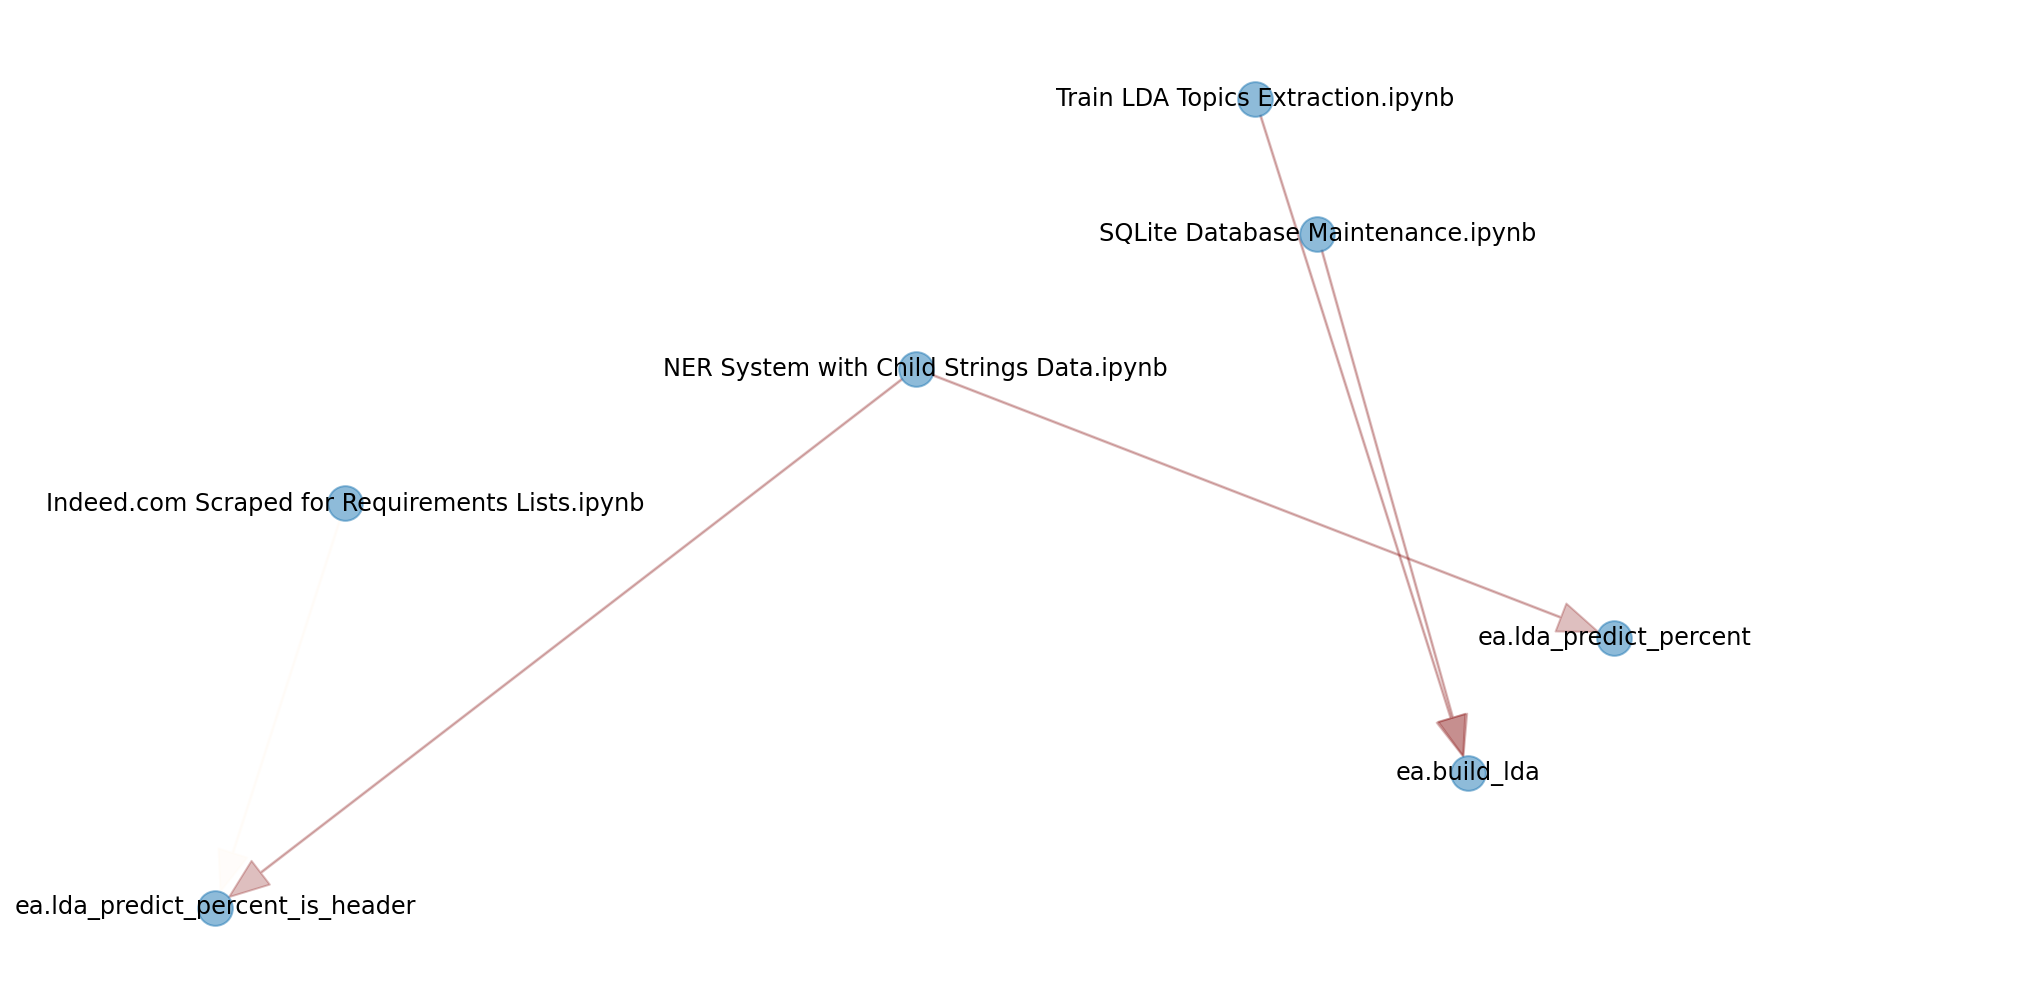

In [161]:

import copy

lda_digraph = copy.copy(notebook_digraph)
for node in list(lda_digraph.nodes()):
    if ('lda' not in node) and (not node.endswith('.ipynb')):
        lda_digraph.remove_node(node)
for node in list(lda_digraph.nodes()):
    if node.endswith('.ipynb') and (len(lda_digraph.out_edges(node)) < 1):
        lda_digraph.remove_node(node)
fruchterman_reingold_layout_dict = nx.fruchterman_reingold_layout(lda_digraph)
plot_graph(lda_digraph, fruchterman_reingold_layout_dict, cmap='OrRd_r', fig_height=9)

In [163]:

lda_digraph.out_edges('Indeed.com Scraped for Requirements Lists.ipynb')

OutEdgeDataView([('Indeed.com Scraped for Requirements Lists.ipynb', 'ea.lda_predict_percent_is_header')])

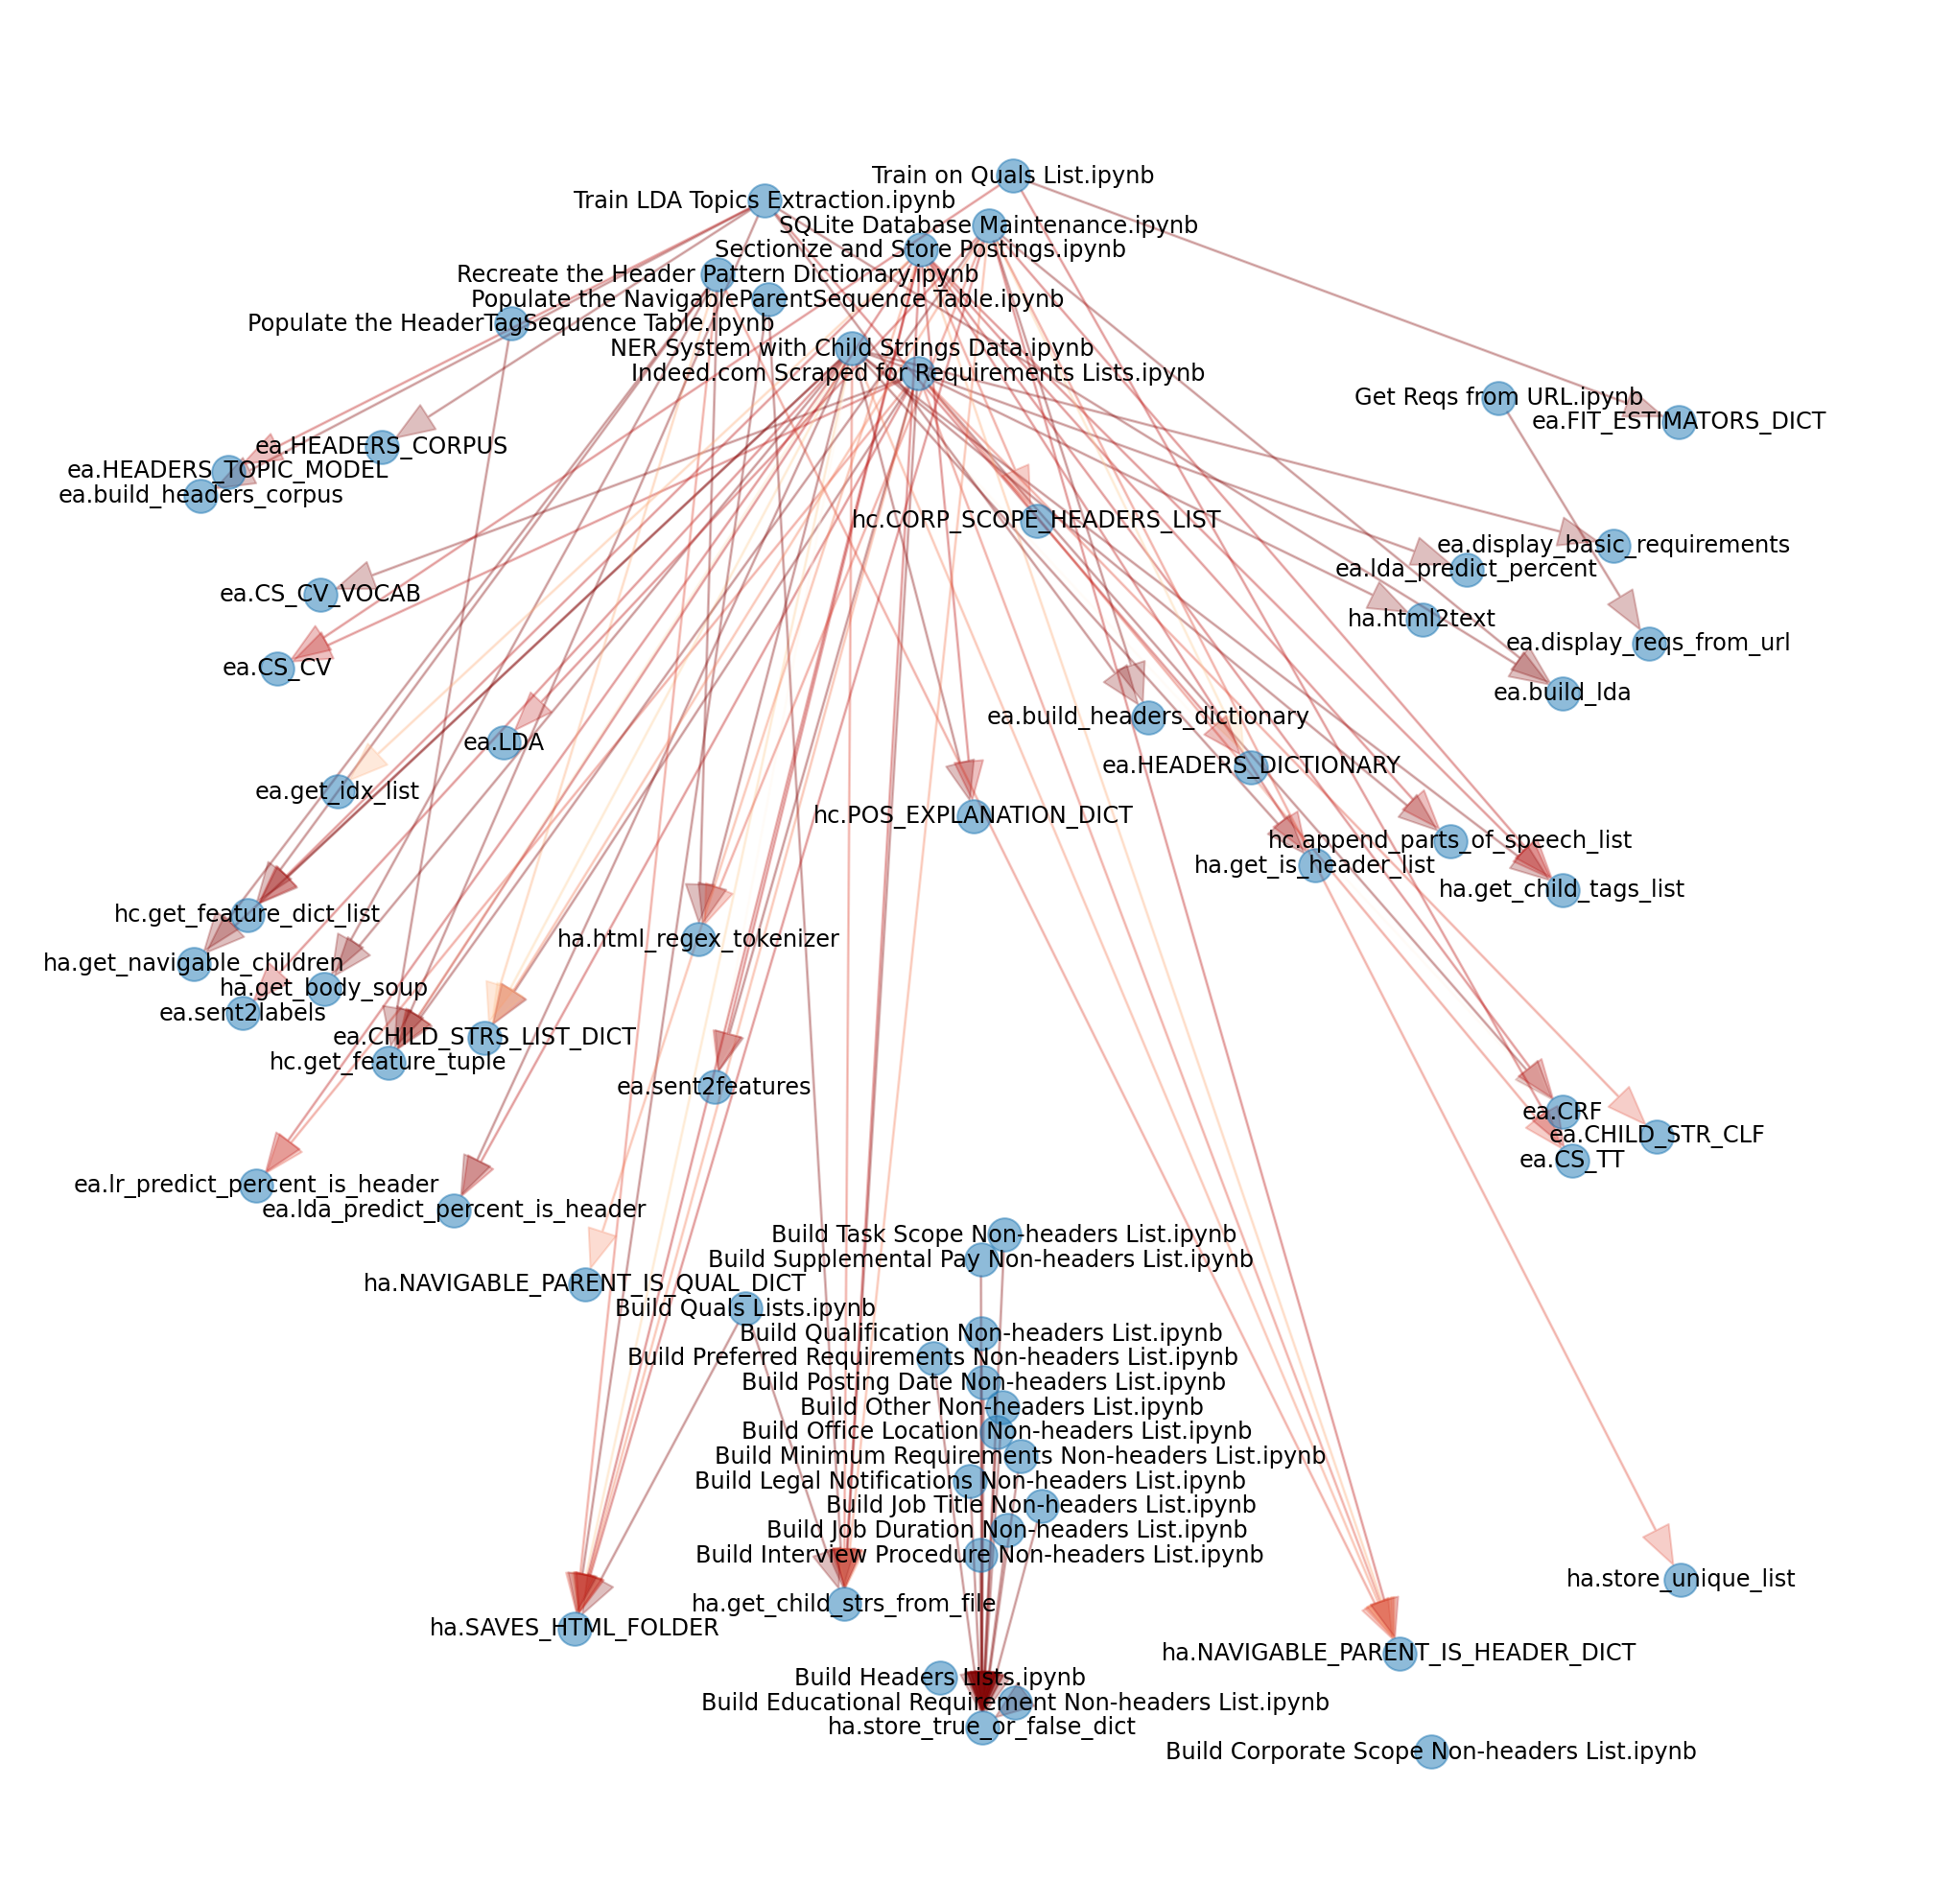

In [135]:

# Draw the graph using various buit-in layouts
#pos = nx.spring_layout(notebook_digraph)
#pos = nx.circular_layout(notebook_digraph)
#pos = nx.random_layout(notebook_digraph)
#pos = nx.spectral_layout(notebook_digraph)
fruchterman_reingold_layout_dict = nx.fruchterman_reingold_layout(notebook_digraph)
#kamada_kawai_layout_dict = nx.kamada_kawai_layout(notebook_digraph)
plot_graph(notebook_digraph, fruchterman_reingold_layout_dict, cmap='OrRd_r')

In [16]:

for node in notebook_digraph.nodes:
    edges_list = notebook_digraph.out_edges(node, data=True)
    if len(edges_list):
        print(edges_list)
        break

[('Build Educational Requirement Non-headers List.ipynb', 'ha.store_true_or_false_dict', {'weight': 1})]


In [17]:

flaskr_folder = r'C:\Users\dev\Documents\Repositories\job-hunting\flaskr'
ha_path = os.path.join(flaskr_folder, 'html_analysis.py')
with open(ha_path, 'r', encoding=s.encoding_type) as f:
    line_list = f.read().split('\n')
idx_list = []
for line_str in line_list:
    if class_regex.search(line_str):
        idx_list.append(line_list.index(line_str))
idx_list

[21, 235, 365]

In [22]:

def beef_up_edge(digraph, from_node, to_node):
    if from_node not in digraph:
        digraph.add_node(from_node)
    if to_node not in digraph:
        digraph.add_node(to_node)
    if digraph.has_edge(from_node, to_node):
        weight = digraph.get_edge_data(from_node, to_node)['weight']
        digraph.edges[from_node, to_node]['weight'] = 1 + weight
    else:
        digraph.add_edge(from_node, to_node, weight=1)
    
    return digraph

In [36]:

def get_lines_list(file_name):
    file_path = os.path.join(sub_directory, file_name)
    try:
        with open(file_path, 'r', encoding=s.encoding_type) as f:
            lines_list = f.read().split('\n')
    except:
        lines_list = []
    
    return lines_list

In [137]:

def get_from_node(idx):
    from_node = '???'
    header_categories_idx = 21
    header_analysis_idx = 235
    element_analysis_idx = 365
    if idx > element_analysis_idx:
        from_node = 'from_ElementAnalysis'
    elif idx > header_analysis_idx:
        from_node = 'from_HeaderAnalysis'
    elif idx > header_categories_idx:
        from_node = 'from_HeaderCategories'
    
    return from_node

In [25]:

def replace_self_dot(idx, line_str):
    header_categories_idx = 21
    header_analysis_idx = 235
    element_analysis_idx = 365
    if idx > element_analysis_idx:
        line_str = line_str.replace('self.', 'ea.')
    elif idx > header_analysis_idx:
        line_str = line_str.replace('self.', 'ha.')
    elif idx > header_categories_idx:
        line_str = line_str.replace('self.', 'hc.')
    
    return line_str

In [138]:

def get_to_node_list(line_str):
    to_node_list = []
    if re.search(r'\bea\.', line_str):
        to_node = 'to_ElementAnalysis'
        to_node_list.append(to_node)
    if re.search(r'\bha\.', line_str):
        to_node = 'to_HeaderAnalysis'
        to_node_list.append(to_node)
    if re.search(r'\bhc\.', line_str):
        to_node = 'to_HeaderCategories'
        to_node_list.append(to_node)
    
    return to_node_list

In [139]:

flaskr_digraph = nx.DiGraph(env='jh')
self_regex = re.compile(r'\bself\.\w+')
for sub_directory, directories_list, files_list in os.walk(flaskr_folder):
    if all(map(lambda x: x not in sub_directory, black_list)):
        for file_name in files_list:
            if file_name.endswith('.py'):
                lines_list = get_lines_list(file_name)
                if (file_name == 'html_analysis.py'):
                    ea_line_list = []; ha_line_list = []; hc_line_list = []
                    for line_str in line_list:
                        idx = line_list.index(line_str)
                        from_node = get_from_node(idx)
                        if self_regex.search(line_str):
                            line_str = replace_self_dot(idx, line_str)
                        to_node_list = get_to_node_list(line_str)
                        for to_node in to_node_list:
                            flaskr_digraph = beef_up_edge(flaskr_digraph, from_node, to_node)
                        if re.search(r'\bea\.', line_str):
                            ea_line_list.append(line_str)
                        if re.search(r'\bha\.', line_str):
                            ha_line_list.append(line_str)
                        if re.search(r'\bhc\.', line_str):
                            hc_line_list.append(line_str)
                    ea_py_str = '\n'.join(ea_line_list); py_str_dict['ElementAnalysis'] = ea_py_str
                    ha_py_str = '\n'.join(ha_line_list); py_str_dict['HeaderAnalysis'] = ha_py_str
                    hc_py_str = '\n'.join(hc_line_list); py_str_dict['HeaderCategories'] = hc_py_str
                else:
                    from_node = file_name
                    new_line_list = []
                    for line_str in line_list:
                        if functions_regex.search(line_str):
                            new_line_list.append(line_str)
                            to_node_list = get_to_node_list(line_str)
                            for to_node in to_node_list:
                                flaskr_digraph = beef_up_edge(flaskr_digraph, from_node, to_node)
                    py_str = '\n'.join(new_line_list); py_str_dict[file_name] = py_str

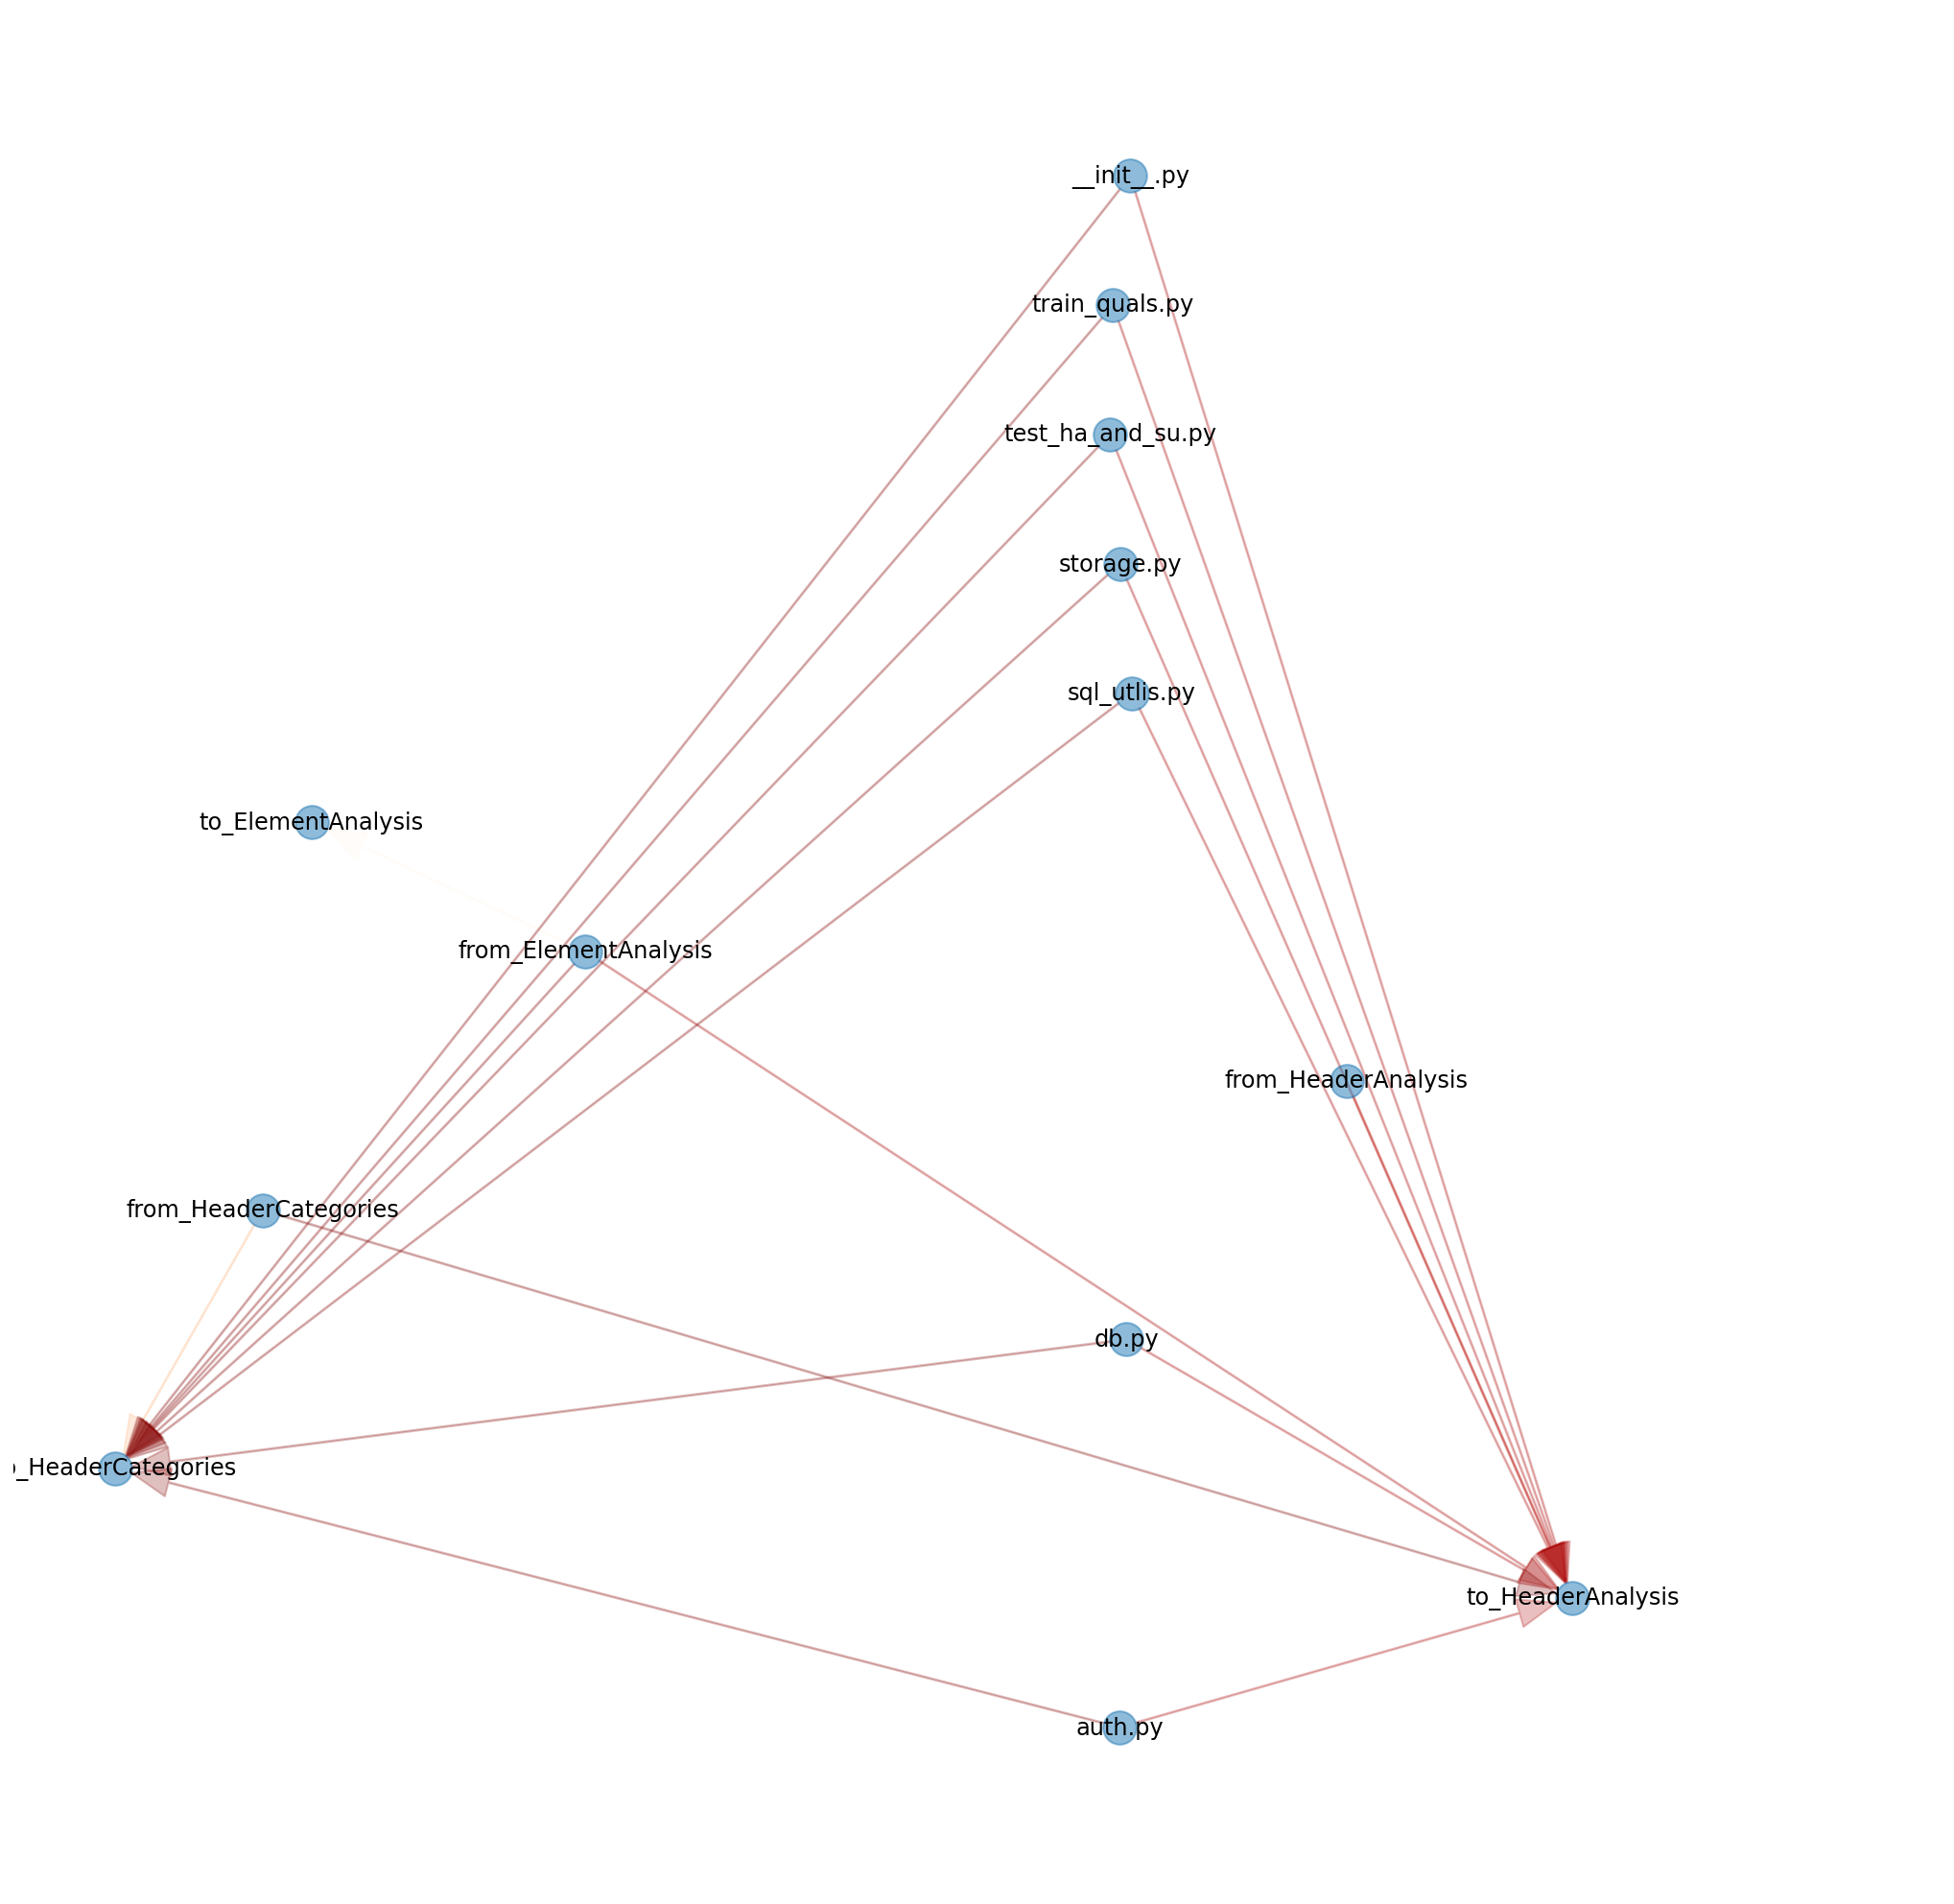

In [140]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline

# Draw the graph using the default spring layout
spring_layout_dict = nx.spring_layout(flaskr_digraph)
#circular_layout_dict = nx.circular_layout(flaskr_digraph)
#random_layout_dict = nx.random_layout(flaskr_digraph)
spectral_layout_dict = nx.spectral_layout(flaskr_digraph)
#fruchterman_reingold_layout_dict = nx.fruchterman_reingold_layout(flaskr_digraph)
#kamada_kawai_layout_dict = nx.kamada_kawai_layout(flaskr_digraph)
plot_graph(flaskr_digraph, spring_layout_dict, cmap='OrRd_r')

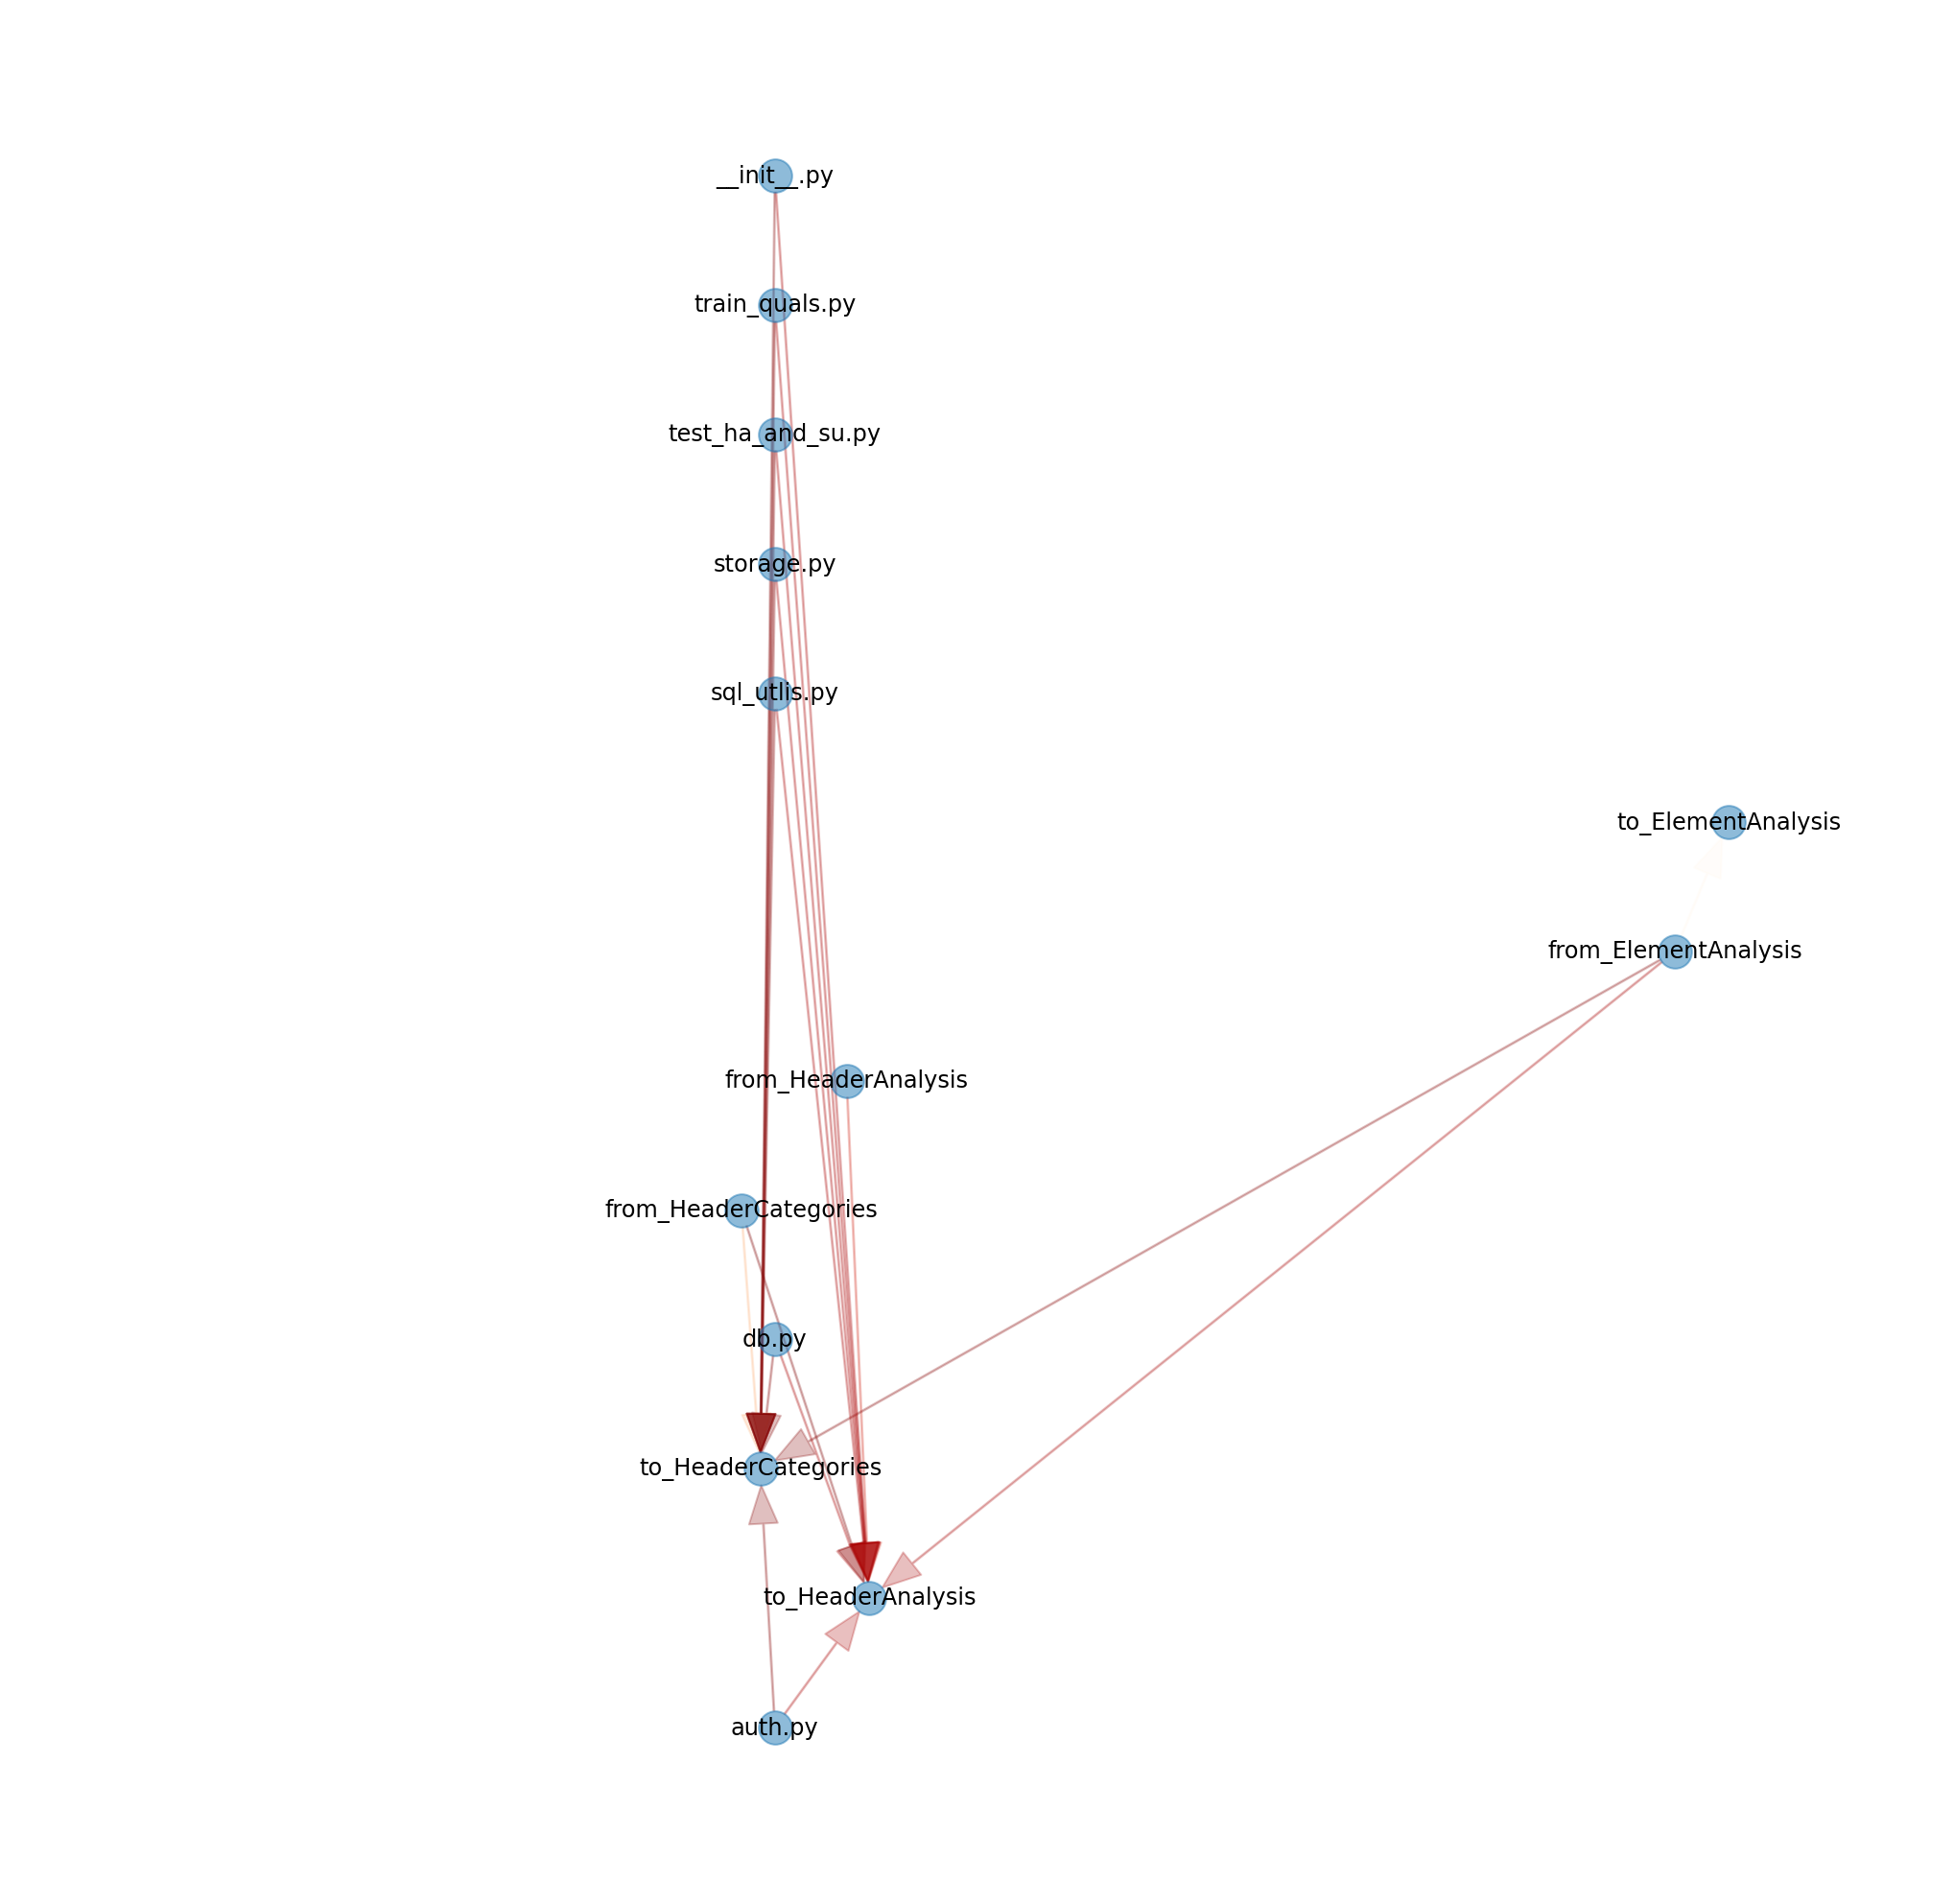

In [141]:


spectral_layout_dict = nx.spectral_layout(flaskr_digraph)
plot_graph(flaskr_digraph, spectral_layout_dict, cmap='OrRd_r')

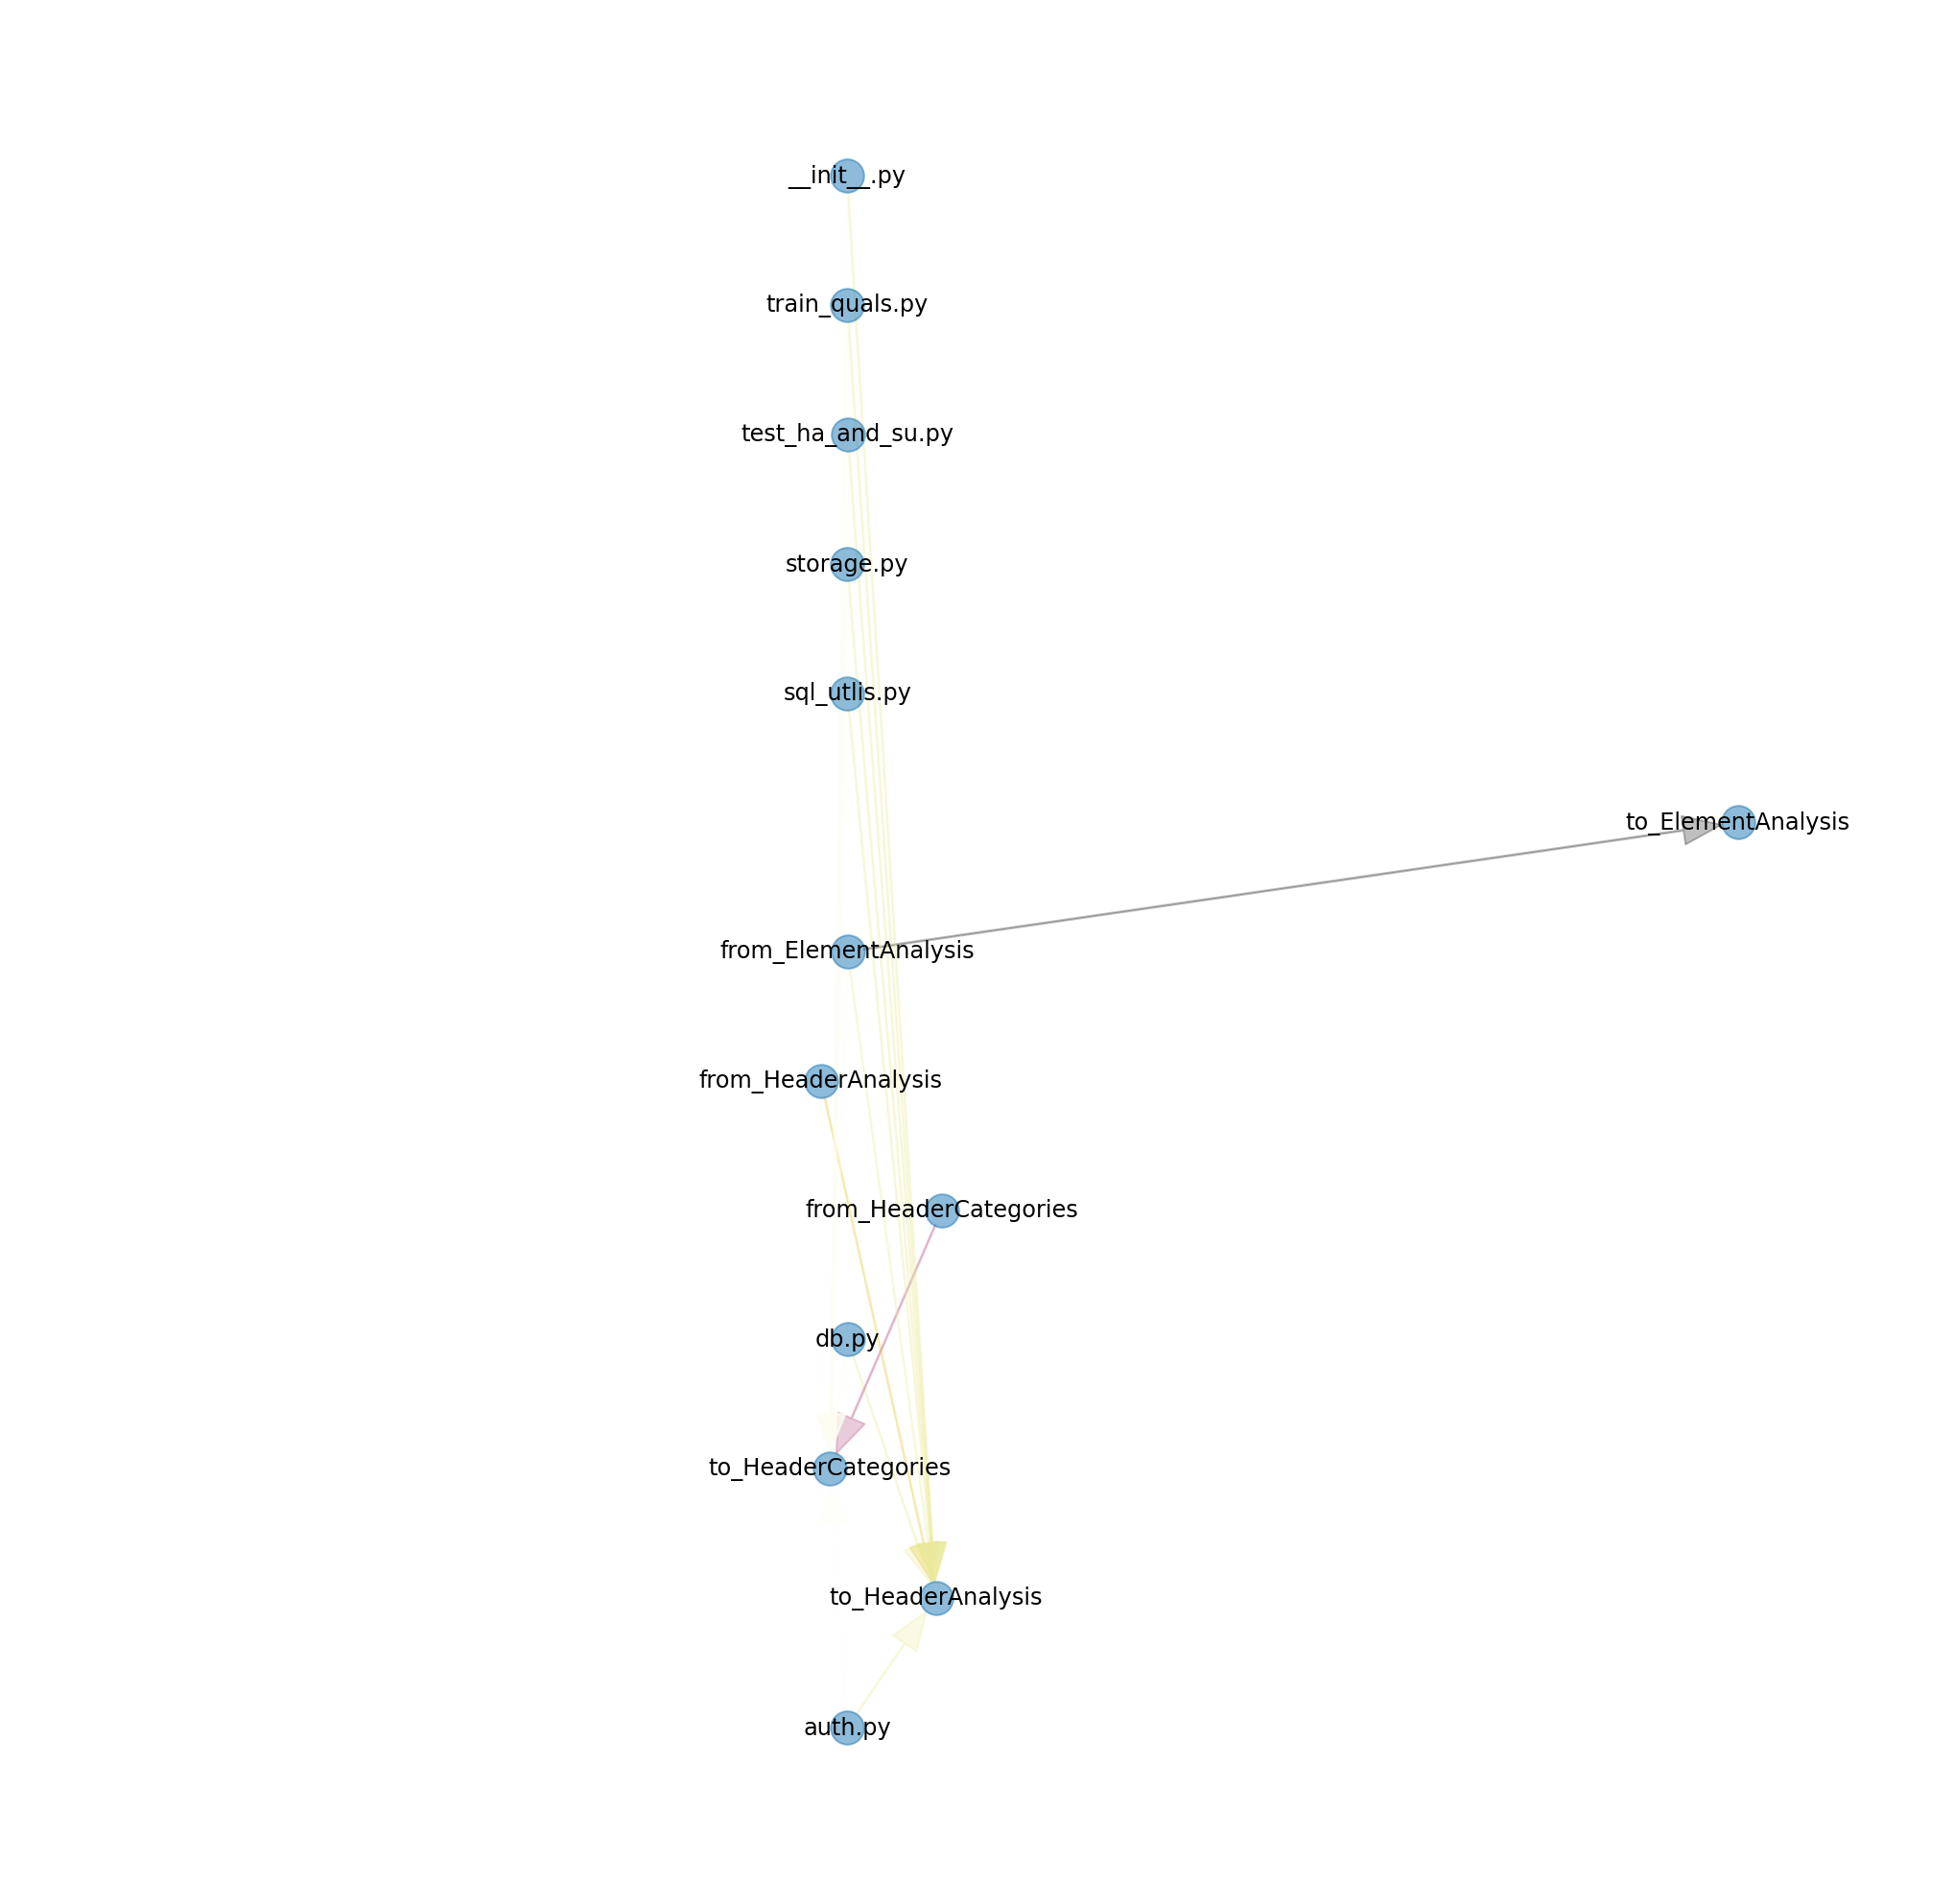

In [142]:

kamada_kawai_layout_dict = nx.kamada_kawai_layout(flaskr_digraph)
plot_graph(flaskr_digraph, kamada_kawai_layout_dict, cmap='CMRmap_r')

In [ ]:

%run ../load_magic/storage.py
%run ../load_magic/dataframes.py
%run ../load_magic/paths.py
%run ../load_magic/lists.py
s = Storage()
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])
[fn for fn in dir() if not fn.startswith('_')]

In [ ]:

print(['notebook_digraph.{}'.format(fn) for fn in dir(notebook_digraph) if not fn.startswith('_')])